In [4]:
from ml_toolkit import df_to_X_y
from ml_toolkit import plot_predictions

import os
import sys
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import mean_squared_error, mean_absolute_error
from tensorflow.keras.optimizers import Adam

| Date                | Point_1_N_mean | PT100_Temperature_mean | Average_Global_Radiation_(1h) | hour | date | year |
|---------------------|----------------|------------------------|-------------------------------|------|------|------|
| 2020-09-02 12:00:00 | 18.324186      | 16.261441              | 954.0                         | 12   | 246  | 2020 |
| 2020-09-03 12:00:00 | 24.667922      | 16.858222              | 966.0                         | 12   | 247  | 2020 |
| 2020-09-04 10:00:00 | -15.535099     | 14.256647              | 131.6                         | 10   | 248  | 2020 |
| 2020-09-04 14:00:00 | -10.819921     | 14.687477              | 314.0                         | 14   | 248  | 2020 |
| 2020-09-04 18:00:00 | -15.399971     | 13.874647              | 236.0                         | 18   | 248  | 2020 |
| ...                 | ...            | ...                    | ...                           | ...  | ...  | ...  |
| 2023-12-31 18:00:00 | -20.227229     | -4.738139              | -3.0                          | 18   | 365  | 2023 |
| 2023-12-31 19:00:00 | -19.488729     | -4.625233              | -3.0                          | 19   | 365  | 2023 |
| 2023-12-31 20:00:00 | -21.503484     | -4.645648              | -2.9                          | 20   | 365  | 2023 |
| 2023-12-31 21:00:00 | -22.667015     | -4.756255              | -2.9                          | 21   | 365  | 2023 |
| 2023-12-31 22:00:00 | -22.800138     | -4.433085              | -3.2                          | 22   | 365  | 2023 |

# Loading data

In [5]:
git_folder = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..', 'HeroysundBridge-ML'))
asset_folder = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..', 'HeroysundBridge-ML-Assets'))

print("Path to git folder:", git_folder)
print("Path to asset folder:", asset_folder)

Path to git folder: c:\Users\erlih\repos\HeroysundBridge-ML
Path to asset folder: c:\Users\erlih\repos\HeroysundBridge-ML-Assets


**Opening file: \silver\combined with relevant columns**

In [6]:
df = pd.read_parquet(os.path.join(asset_folder, 'silver','combined_data_v01.parquet'))
df.index = pd.to_datetime(df['Date'], format='%Y%m%d%H')
df.to_csv(os.path.join(asset_folder, 'silver','inspection.csv'))

**Adding relevant time/dates columns**

In [7]:
model_dataset = df[['Point_1_N_mean', 'PT100_Temperature_mean', 'Average_Global_Radiation_(1h)']]
model_dataset.loc[:, 'time_unit'] = pd.to_datetime(df['Date'], format='%Y%m%d%H')

model_dataset['hour'] = model_dataset['time_unit'].dt.hour
model_dataset['date'] = model_dataset['time_unit'].dt.dayofyear
model_dataset['year'] = model_dataset['time_unit'].dt.year

model_dataset.drop(columns=['time_unit'], inplace=True)  # Drop the temporary column if needed

C:\Users\erlih\AppData\Local\Temp\ipykernel_29732\3961593232.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_dataset.loc[:, 'time_unit'] = pd.to_datetime(df['Date'], format='%Y%m%d%H')
C:\Users\erlih\AppData\Local\Temp\ipykernel_29732\3961593232.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_dataset['hour'] = model_dataset['time_unit'].dt.hour
C:\Users\erlih\AppData\Local\Temp\ipykernel_29732\3961593232.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

# Train-, val- and testing split +++ Scaling

In [8]:
window_size = 24

dataset_size = len(model_dataset)
training_split = int(0.72 * dataset_size)
validation_split = int(0.18 * dataset_size)
test_split = dataset_size - training_split - validation_split
print(f"Training split: {training_split}, Validation split: {validation_split}, Test split: {test_split}")
assert training_split + validation_split + test_split == dataset_size, "Invalid split sizes"

Training split: 19304, Validation split: 4826, Test split: 2682


**Assigning labels and targets - x- and y- train,-val and -test**

In [9]:
X, y = df_to_X_y(model_dataset, window_size)
print(X.shape, y.shape)

# Splitting the data into training, validation and test sets
X_train, y_train = X[:training_split], y[:training_split]
X_valid, y_valid = X[training_split:(training_split + validation_split)], y[training_split:(training_split + validation_split)]
X_test, y_test = X[-test_split:], y[-test_split:]
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape)

(26806, 6, 5) (26806,)
(19304, 6, 5) (19304,) (4826, 6, 5) (4826,) (2682, 6, 5) (2682,)


**Normlaization**

In [10]:
# Reshape to 2D (Normalisation requires 2D input)
X_train_2D = np.reshape(X_train, (X_train.shape[0] * X_train.shape[1], X_train.shape[2]))
X_valid_2D = np.reshape(X_valid, (X_valid.shape[0] * X_valid.shape[1], X_valid.shape[2]))
X_test_2D = np.reshape(X_test, (X_test.shape[0] * X_test.shape[1], X_test.shape[2]))

# Apply scaling
scaler_x = StandardScaler()
X_train_scaled_2D = scaler_x.fit_transform(X_train_2D)
X_valid_scaled_2D = scaler_x.transform(X_valid_2D)
X_test_scaled_2D = scaler_x.transform(X_test_2D)

# Reshape back to 3D
X_train_scaled = np.reshape(X_train_scaled_2D, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_valid_scaled = np.reshape(X_valid_scaled_2D, (X_valid.shape[0], X_valid.shape[1], X_valid.shape[2]))
X_test_scaled = np.reshape(X_test_scaled_2D, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_valid_scaled = scaler_y.transform(y_valid.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

# LSTM Model 1

In [11]:
model_name = 'lstm_model_1'
batch_size = 128
epochs = 100
learning_rate = 0.001
patience = 10
verbose = 0
saving_frequency = 8

In [12]:
model = Sequential()
model.add(InputLayer((window_size, (len(model_dataset.columns)-1))))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 64)             17920     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 8)                 264       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 30609 (119.57 KB)
Trainable params: 30609 (119.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
cp = ModelCheckpoint(os.path.join(asset_folder, 'gold', str(model_name)), save_best_only=True, mode='auto', verbose=verbose)
es = EarlyStopping(monitor='val_loss', patience=patience, mode='auto', verbose=verbose)
model.compile(optimizer=Adam(learning_rate), loss=mean_absolute_error, metrics=['mae'])
history = model.fit(X_train_scaled, y_train_scaled, validation_data=(X_valid_scaled, y_valid_scaled), epochs=epochs, batch_size=batch_size, callbacks=[es,cp], verbose=verbose) 



INFO:tensorflow:Assets written to: c:\Users\erlih\repos\HeroysundBridge-ML-Assets\gold\lstm_model_1\assets


INFO:tensorflow:Assets written to: c:\Users\erlih\repos\HeroysundBridge-ML-Assets\gold\lstm_model_1\assets


INFO:tensorflow:Assets written to: c:\Users\erlih\repos\HeroysundBridge-ML-Assets\gold\lstm_model_1\assets


INFO:tensorflow:Assets written to: c:\Users\erlih\repos\HeroysundBridge-ML-Assets\gold\lstm_model_1\assets


INFO:tensorflow:Assets written to: c:\Users\erlih\repos\HeroysundBridge-ML-Assets\gold\lstm_model_1\assets


INFO:tensorflow:Assets written to: c:\Users\erlih\repos\HeroysundBridge-ML-Assets\gold\lstm_model_1\assets


INFO:tensorflow:Assets written to: c:\Users\erlih\repos\HeroysundBridge-ML-Assets\gold\lstm_model_1\assets


INFO:tensorflow:Assets written to: c:\Users\erlih\repos\HeroysundBridge-ML-Assets\gold\lstm_model_1\assets


INFO:tensorflow:Assets written to: c:\Users\erlih\repos\HeroysundBridge-ML-Assets\gold\lstm_model_1\assets


INFO:tensorflow:Assets written to: c:\Users\erlih\repos\HeroysundBridge-ML-Assets\gold\lstm_model_1\assets


INFO:tensorflow:Assets written to: c:\Users\erlih\repos\HeroysundBridge-ML-Assets\gold\lstm_model_1\assets


INFO:tensorflow:Assets written to: c:\Users\erlih\repos\HeroysundBridge-ML-Assets\gold\lstm_model_1\assets


INFO:tensorflow:Assets written to: c:\Users\erlih\repos\HeroysundBridge-ML-Assets\gold\lstm_model_1\assets


INFO:tensorflow:Assets written to: c:\Users\erlih\repos\HeroysundBridge-ML-Assets\gold\lstm_model_1\assets


**Visualization of ML-metrics**

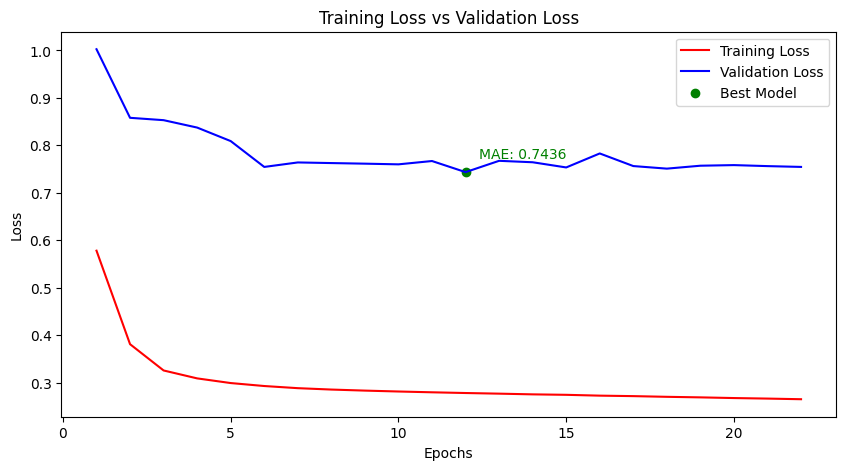

In [14]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Get the number of epochs
epochs = range(1, len(train_loss) + 1)

# Get the index of the best model
best_model_index = np.argmin(val_loss)

# Plot the training loss vs validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.scatter(best_model_index + 1, val_loss[best_model_index], color='g', label='Best Model')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the MAE value of the best model
best_model_mae = val_loss[best_model_index]
plt.annotate(f'MAE: {best_model_mae:.4f}', (best_model_index + 1, best_model_mae), xytext=(10, 10),
             textcoords='offset points', color='g')

plt.show()

### Predictions

84/84 [==============================] - 1s 2ms/step


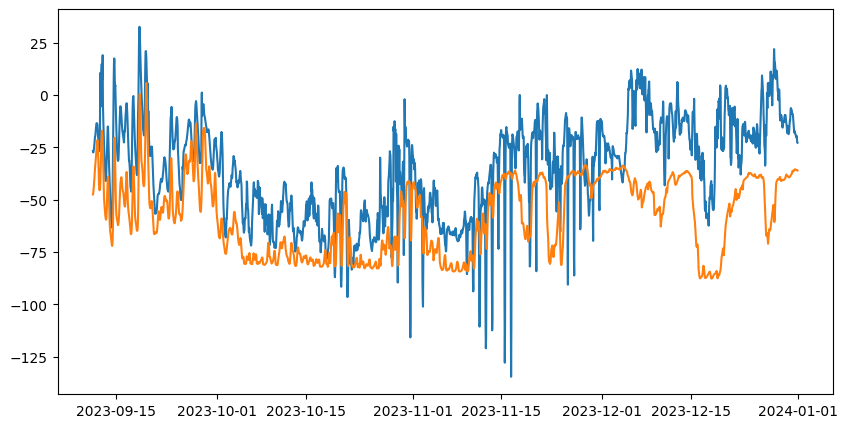

MSE: 800.9722290039062
MAE: 24.209697723388672


,Predictions,Actuals
0,-47.458252,-26.868450
1,-46.787693,-27.434437
2,-45.686317,-27.154563
3,-44.292763,-26.173874
4,-42.656467,-25.681637
...,...,...
2677,-35.878803,-20.227229
2678,-35.875198,-19.488729
2679,-35.864830,-21.503484
2680,-35.929859,-22.667015


In [15]:
model_file_path = os.path.join(asset_folder, 'gold', model_name)
model = load_model(model_file_path)
plot_predictions(model_dataset, test_split, model, X_test_scaled, y_test, start=0, end=test_split, scaler=scaler_y)